# Business & Data Understanding

My goal is to build a model to help Spotify classify songs into genres - this will enable Spotify to provide song recommedations to users building genre-based playlists. I will accomplish this using song features sourced from Spotify's API:

+ Genre - the genre of the track <br>
+ Year - the release year of the recording
+ Added - the earliest date you added the track to your collection <br>
+ Energy - The energy of a song - the higher the value, the more energtic <br>
+ Danceability - The higher the value, the easier it is to dance to this song <br>
+ Loudness (dB) - The higher the value, the louder the song <br>
+ Liveness - The higher the value, the more likely the song is a live recording <br>
+ Valence - The higher the value, the more positive mood for the song <br>
+ Length - The duration of the song <br>
+ Acousticness - The higher the value the more acoustic the song is <br>
+ Speechiness - The higher the value the more spoken word the song contains <br>
+ Popularity - The higher the value the more popular the song is <br>
+ Duration - The length of the song <br>
+ Mode - Major (1) or Minor  (0)
+ Instrumentalness - the closer the value to 1, the more instrumental

This is a balanced, multi-class classification algorithm - all genre classifications have equal importance and therefore equal weight.

Try GridSearchCV for hyperparameter tuning since dataset is relatively small

# Data Preparation

In [143]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE, ADASYN


import warnings
warnings.filterwarnings('ignore')

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [144]:
# Read the raw data into a dataframe

df = pd.read_excel('spotify_genre_final.xlsx')

In [145]:
# Inspect the dataframe

df.head()

,Genre,Title,Album_cover_link,Artist,duration_ms,explicit,id,popularity,release_date,release_date_precision,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,rock,Baba O'Riley,https://i.scdn.co/image/ab67616d0000b273fe24dc...,The Who,300400,False,3qiyyUfYe7CRYLucrPmulD,75,1971-08-14,day,...,5,-8.367,1,0.0352,0.31300,0.185000,0.2870,0.150,117.292,4
1,rock,More Than a Feeling,https://i.scdn.co/image/ab67616d0000b27390ef97...,Boston,285133,False,1QEEqeFIZktqIpPI4jSVSF,78,1976,year,...,7,-8.039,1,0.0298,0.00088,0.002300,0.0504,0.285,108.789,4
2,rock,(Don't Fear) The Reaper,https://i.scdn.co/image/ab67616d0000b2733ac318...,Blue Öyster Cult,308120,False,5QTxFnGygVM4jFQiBovmRo,76,1976,year,...,9,-8.550,0,0.0733,0.00290,0.000208,0.2970,0.385,141.466,4
3,rock,Jump - 2015 Remaster,https://i.scdn.co/image/ab67616d0000b273b414c6...,Van Halen,241599,False,7N3PAbqfTjSEU1edb2tY8j,78,1984-01-04,day,...,0,-6.219,1,0.0317,0.17100,0.000377,0.0702,0.795,129.981,4
4,rock,Stairway to Heaven - Remaster,https://i.scdn.co/image/ab67616d0000b273c8a11e...,Led Zeppelin,482830,False,5CQ30WqJwcep0pYcV4AMNc,79,1971-11-08,day,...,9,-12.049,0,0.0339,0.58000,0.003200,0.1160,0.197,82.433,4


From an initial inspection there seem to be a few rows worth removing - album_cover_link for example does not give us any useful information for analysis. Title and Artist might not be so useful either considering these are categorical features with presumably many unique values.

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6917 entries, 0 to 6916
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Genre                   6917 non-null   object 
 1   Title                   6917 non-null   object 
 2   Album_cover_link        6917 non-null   object 
 3   Artist                  6917 non-null   object 
 4   duration_ms             6917 non-null   int64  
 5   explicit                6917 non-null   bool   
 6   id                      6917 non-null   object 
 7   popularity              6917 non-null   int64  
 8   release_date            6917 non-null   object 
 9   release_date_precision  6917 non-null   object 
 10  total_tracks            6917 non-null   int64  
 11  danceability            6917 non-null   float64
 12  energy                  6917 non-null   float64
 13  key                     6917 non-null   int64  
 14  loudness                6917 non-null   

The dataset includes mostly numeric features with the exception of a few categorical features. For the purposes of my analysis I am going to drop Artist, Album_cover_link, Title, release_date, and release_date_precision because these would create too many additional features if I were to One-Hot-Encode them. There are also a few boolean features (explicit, mode) which I will treat as categorical.

Additionally the dataset does not appear to have any null values which is a good sign.

In [147]:
df.describe()

,duration_ms,popularity,total_tracks,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,6917.000000,6917.000000,6917.000000,6917.000000,6917.000000,6917.000000,6917.000000,6917.000000,6917.000000,6917.000000,6917.000000,6917.000000,6917.000000,6917.000000,6917.000000
mean,230325.976579,60.491543,11.780541,0.663048,0.680214,5.348851,-6.725942,0.584357,0.111231,0.178805,0.034783,0.184376,0.538109,120.034788,3.972531
std,54336.723207,12.944708,8.268982,0.151653,0.173824,3.617507,2.783829,0.492868,0.096413,0.214174,0.138639,0.147764,0.233274,28.015297,0.247247
min,120133.000000,0.000000,1.000000,0.142000,0.084800,0.000000,-20.567000,0.000000,0.022400,0.000002,0.000000,0.013600,0.026000,52.145000,1.000000
25%,193466.000000,53.000000,8.000000,0.562000,0.562000,2.000000,-8.166000,0.000000,0.040600,0.020400,0.000000,0.091600,0.356000,96.571000,4.000000
50%,223733.000000,62.000000,12.000000,0.679000,0.696000,6.000000,-6.258000,1.000000,0.064500,0.088000,0.000002,0.125000,0.546000,120.010000,4.000000
75%,259853.000000,69.000000,16.000000,0.775000,0.818000,8.000000,-4.787000,1.000000,0.157000,0.261000,0.000470,0.236000,0.728000,136.029000,4.000000
max,591693.000000,100.000000,125.000000,0.983000,0.998000,11.000000,0.878000,1.000000,0.399000,0.983000,0.973000,0.979000,0.985000,214.025000,5.000000


From the above table I'm noticing that although time_signature is a numeric field, I should actually treat it as categorical since there is no scale to its values (i.e. time_signature = 2 is not greater than time_Signature = 1).

In [148]:
# Class Frequency of Target Variable

df['Genre'].value_counts()

pop       1161
rock      1136
latin     1036
hiphop     971
edm        956
rap        926
r&b        731
Name: Genre, dtype: int64

Class frequency is relatively evenly-distributed, however there is still some imbalance here with r&b being the least represented genre and rock being the most represented. This is something to keep in mind while evaluating modeling performance - perhaps it would be a good idea to even this distribution using SMOTE to give the model a fair chance at learning each genre's nuances.

# Modeling

### *Baseline Model - Decision Tree*

In [149]:
# Split the data into train and test sets ahead of pre-processing

y = df['Genre']
X = df.drop(columns = ['Genre', 'Artist', 'Title', 'Album_cover_link', 'release_date_precision', 'release_date', 'id'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [150]:
# Pre-Processing (Train)

X_train_categoricals = X_train[['explicit', 'key', 'time_signature', 'mode']]
X_train_categoricals['explicit'] = X_train_categoricals.explicit.astype('category')
X_train_categoricals['key'] = X_train_categoricals.key.astype('category')
X_train_categoricals['time_signature'] = X_train_categoricals.time_signature.astype('category')
X_train_categoricals['mode'] = X_train_categoricals['mode'].astype('category')


X_train_dummies = pd.get_dummies(X_train_categoricals, drop_first = True)
X_train_numeric = X_train.drop(columns = X_train_categoricals.columns)

X_train_OHE = pd.concat([X_train_numeric, X_train_dummies], axis = 1)
X_train_OHE

,duration_ms,popularity,total_tracks,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_3,time_signature_4,time_signature_5,mode_1
2773,194750,45,15,0.446,0.732,-6.428,0.0361,0.00767,0.000000,0.1310,...,0,0,0,0,0,0,0,1,0,0
5172,180596,79,1,0.684,0.506,-6.743,0.0338,0.15900,0.000000,0.2600,...,1,0,0,0,0,0,0,1,0,1
726,221640,70,13,0.699,0.502,-12.526,0.0278,0.06070,0.033700,0.3170,...,0,0,0,1,0,0,0,1,0,1
319,194288,64,19,0.415,0.950,-4.676,0.0621,0.00126,0.000039,0.1330,...,0,0,0,0,0,0,0,1,0,1
5382,173600,75,14,0.797,0.844,-5.482,0.2750,0.06510,0.000000,0.0870,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,262800,62,12,0.737,0.890,-8.443,0.1580,0.00556,0.001710,0.0801,...,0,0,0,0,0,0,0,1,0,1
4060,201122,77,15,0.694,0.712,-3.923,0.0460,0.13200,0.000000,0.2110,...,0,1,0,0,0,0,0,1,0,0
1346,208272,59,21,0.705,0.611,-6.772,0.2360,0.03090,0.000000,0.0903,...,0,0,0,0,0,0,0,1,0,0
3454,176093,11,12,0.809,0.550,-11.264,0.0392,0.69000,0.000007,0.1120,...,0,0,0,1,0,0,0,1,0,1


In [151]:
# Pre-Processing (Test)

X_test_categoricals = X_test[['explicit', 'key', 'time_signature', 'mode']]
X_test_categoricals['explicit'] = X_test_categoricals.explicit.astype('category')
X_test_categoricals['key'] = X_test_categoricals.key.astype('category')
X_test_categoricals['time_signature'] = X_test_categoricals.time_signature.astype('category')
X_test_categoricals['mode'] = X_test_categoricals['mode'].astype('category')


X_test_dummies = pd.get_dummies(X_test_categoricals, drop_first = True)
X_test_numeric = X_test.drop(columns = X_test_categoricals.columns)

X_test_OHE = pd.concat([X_test_numeric, X_test_dummies], axis = 1)
X_test_OHE

,duration_ms,popularity,total_tracks,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_3,time_signature_4,time_signature_5,mode_1
4075,186986,81,18,0.697,0.6830,-2.881,0.1170,0.0372,0.000000,0.1370,...,0,0,0,0,0,0,0,1,0,0
6550,201493,70,14,0.332,0.6350,-5.653,0.0898,0.1590,0.000003,0.0599,...,0,1,0,0,0,0,1,0,0,1
6021,298493,47,19,0.889,0.7130,-4.845,0.2280,0.0181,0.000000,0.0715,...,0,0,0,0,0,0,0,1,0,1
1126,165426,69,13,0.380,0.0993,-20.567,0.0509,0.9140,0.000023,0.0605,...,0,0,0,0,0,0,0,1,0,1
5364,338853,75,16,0.375,0.8620,-3.363,0.2550,0.0710,0.000000,0.2110,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,240341,75,14,0.610,0.4580,-11.336,0.3600,0.6960,0.000103,0.0852,...,0,0,0,1,0,0,0,1,0,1
6028,221626,60,20,0.462,0.9440,-2.938,0.3150,0.3120,0.000149,0.3670,...,0,0,1,0,0,0,0,1,0,1
3087,235133,63,20,0.651,0.9120,-3.402,0.2230,0.0969,0.000040,0.1070,...,0,1,0,0,0,0,0,1,0,1
4488,188386,81,11,0.744,0.6190,-9.805,0.0390,0.5980,0.003720,0.2310,...,0,0,0,0,0,0,0,1,0,1


I am pre-processing train and test sets separately post-split so as to avoid data leakage. We want to ensure that the test dataset is as close to "new" or "unseen" to our trained model as possible. Next I will fit the baseline Decision Tree Classifier model on the pre-processed training data.

In [152]:
# Fit a baseline Decision Tree Classifier model

DTC = DecisionTreeClassifier(criterion = 'entropy', random_state = 10)
DTC.fit(X_train_OHE, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=10)

In [153]:
# Make predictions on the training set

y_pred_train = DTC.predict(X_train_OHE)

print('Train Accuracy Score:',balanced_accuracy_score(y_train, y_pred_train))

y_pred_train_proba = DTC.predict_proba(X_train_OHE)
print('Train AUC Score:', roc_auc_score(y_train, y_pred_train_proba, multi_class = 'ovr'))

# Make predictions on the test set

y_pred_test = DTC.predict(X_test_OHE)

print('Test Accuracy Score:', balanced_accuracy_score(y_test, y_pred_test))

y_pred_test_proba = DTC.predict_proba(X_test_OHE)
print('Test AUC Score:', roc_auc_score(y_test, y_pred_test_proba, multi_class = 'ovr'))

Train Accuracy Score: 0.8857016762435178
Train AUC Score: 0.9933456361031014
Test Accuracy Score: 0.4033407146280988
Test AUC Score: 0.6628007865493739


In [154]:
# Check classification report for train set

print('Train:')
print(classification_report(y_train, y_pred_train))

# Check classification report for test set

print('Test:')
print(classification_report(y_test, y_pred_test))

Train:
              precision    recall  f1-score   support

         edm       0.92      1.00      0.96       743
      hiphop       0.66      1.00      0.80       792
       latin       0.99      1.00      0.99       839
         pop       0.90      0.92      0.91       937
         r&b       0.99      0.80      0.88       576
         rap       1.00      0.49      0.66       748
        rock       1.00      0.99      1.00       898

    accuracy                           0.90      5533
   macro avg       0.92      0.89      0.89      5533
weighted avg       0.92      0.90      0.89      5533

Test:
              precision    recall  f1-score   support

         edm       0.63      0.55      0.59       213
      hiphop       0.25      0.35      0.29       179
       latin       0.48      0.46      0.47       197
         pop       0.35      0.42      0.38       224
         r&b       0.29      0.27      0.28       155
         rap       0.21      0.16      0.18       178
        roc

It looks like the baseline model is performing well on the training data, but not very well on the testing data - which suggests overfitting. I will need to tune my model's hyperparameters to adjust for this. We can also see that the model is performing better on certain genres compared to others. For example we can see on both the training and test data tthe model performed best on rock, and worst on rap as shown by the f1-score.

Additionally, I will perform SMOTE resampling to adjust for class imbalance.

In [155]:
# Perform SMOTE resampling on the train set

print(y_train.value_counts())

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train_OHE, y_train)

print(pd.Series(y_train_resampled).value_counts()) 

pop       937
rock      898
latin     839
hiphop    792
rap       748
edm       743
r&b       576
Name: Genre, dtype: int64
rap       937
latin     937
pop       937
r&b       937
edm       937
hiphop    937
rock      937
Name: Genre, dtype: int64


In [156]:
# Perform SMOTE resampling on the test set

X_test_resampled, y_test_resampled = SMOTE().fit_resample(X_test_OHE, y_test)

In [157]:
# Fit a new model on the resampled train set, make predictions on the resampled train and set sets

DTC2 = DecisionTreeClassifier(criterion = 'entropy', random_state = 10)
DTC2.fit(X_train_resampled, y_train_resampled)

y_pred_train_2 = DTC2.predict(X_train_resampled)
y_pred_test_2 = DTC2.predict(X_test_resampled)

In [158]:
# Check to see how train scores have been impacted

print(classification_report(y_train_resampled, y_pred_train_2))

              precision    recall  f1-score   support

         edm       0.94      1.00      0.97       937
      hiphop       0.70      1.00      0.82       937
       latin       0.99      1.00      0.99       937
         pop       0.90      0.92      0.91       937
         r&b       0.99      0.87      0.93       937
         rap       1.00      0.60      0.75       937
        rock       1.00      0.99      1.00       937

    accuracy                           0.91      6559
   macro avg       0.93      0.91      0.91      6559
weighted avg       0.93      0.91      0.91      6559



In [159]:
# Check to see how test scores have been impacted

print(classification_report(y_test_resampled, y_pred_test_2))

              precision    recall  f1-score   support

         edm       0.62      0.59      0.60       238
      hiphop       0.29      0.36      0.32       238
       latin       0.44      0.40      0.42       238
         pop       0.26      0.29      0.27       238
         r&b       0.39      0.35      0.37       238
         rap       0.25      0.20      0.22       238
        rock       0.62      0.64      0.63       238

    accuracy                           0.40      1666
   macro avg       0.41      0.40      0.40      1666
weighted avg       0.41      0.40      0.40      1666



Resampling alone did not impact model performance sigificantly - only 1% increase in train accuracy and on impact on test accuracy. Next I will tune model hyperparameters to see how that affects model performance.

In [308]:
## Function for tuning hyperparameters to adjust for overfitting - DTC

def hyper_param_tuning_DTC(feature, feature_range):
    
    train_AUC_results_total = []
    test_AUC_results_total = []
    train_accuracy_results_total = []
    test_accuracy_results_total = []
    
    for value in feature_range:
        if feature == 'max_depth':
            DTC = DecisionTreeClassifier(max_depth = value, random_state = 1)
        elif feature == 'max_features':
            DTC = DecisionTreeClassifier(max_features = value, random_state = 1)
        elif feature == 'criterion':
            DTC = DecisionTreeClassifier(criterion = value, random_state = 1)
        elif feature == 'min_samples_leaf':
            DTC = DecisionTreeClassifier(min_samples_leaf = value, random_state = 1)
        elif feature == 'min_samples_split':
            DTC = DecisionTreeClassifier(min_samples_split = value, random_state = 1)

        DTC.fit(X_train_resampled, y_train_resampled)
        y_pred_train_proba = DTC.predict_proba(X_train_resampled)
        roc_auc_train = roc_auc_score(y_train_resampled, y_pred_train_proba, multi_class = 'ovr')
        y_pred_train = DTC.predict(X_train_resampled)
        train_accuracy = accuracy_score(y_train_resampled, y_pred_train)

        y_pred_test_proba = DTC.predict_proba(X_test_resampled)
        roc_auc_test = roc_auc_score(y_test_resampled, y_pred_test_proba, multi_class = 'ovr')
        y_pred_test = DTC.predict(X_test_resampled)
        test_accuracy = accuracy_score(y_test_resampled, y_pred_test)

        scores = {'Train AUC': roc_auc_train, 
        'Train Accuracy' : train_accuracy, 
        'Test AUC' : roc_auc_test, 
        'Test Accuracy' : test_accuracy}

        train_AUC_results_total.append(scores['Train AUC'])
        test_AUC_results_total.append(scores['Test AUC'])
        train_accuracy_results_total.append(scores['Train Accuracy'])
        test_accuracy_results_total.append(scores['Test Accuracy'])
    
    
            
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (24,8))

    ax1.plot(feature_range, train_AUC_results_total, 'b', label='Train AUC')
    ax1.plot(feature_range, test_AUC_results_total, 'r', label='Test AUC')
    ax1.set_ylabel('AUC Score')
    ax1.set_xlabel(feature)
    ax1.set_title('DTC - AUC vs.' + feature)
    ax1.legend()

    ax2.plot(feature_range, train_accuracy_results_total, 'b', label='Train Accuracy')
    ax2.plot(feature_range, test_accuracy_results_total, 'r', label='Test Accuracy')
    ax2.set_ylabel('Accuracy Score')
    ax2.set_xlabel(feature)
    ax2.set_title('DTC - Accuracy vs.' + feature)
    ax2.legend()

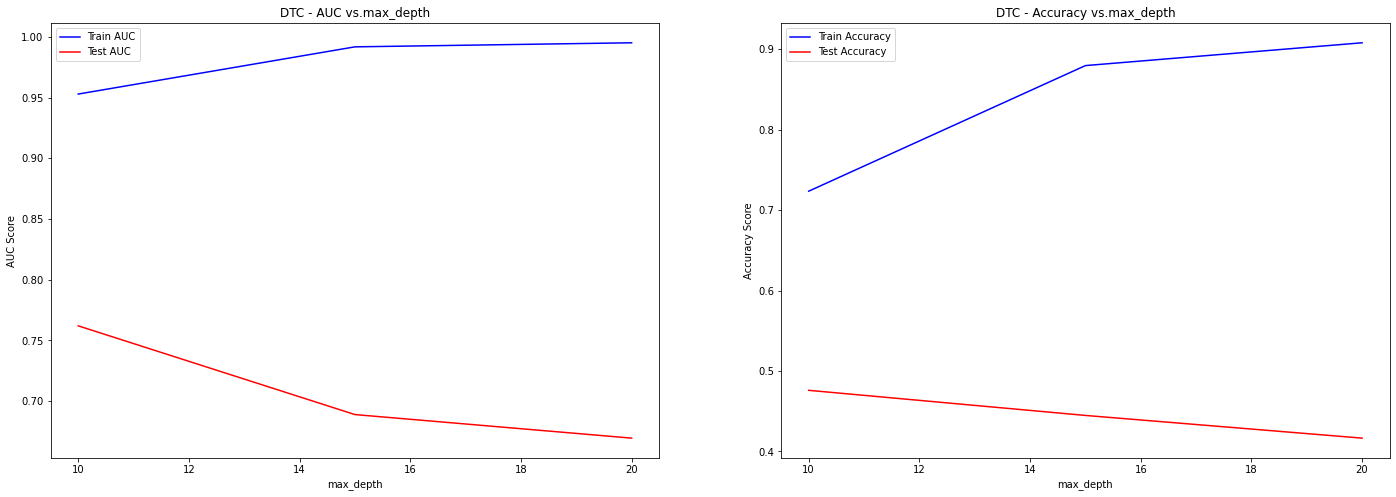

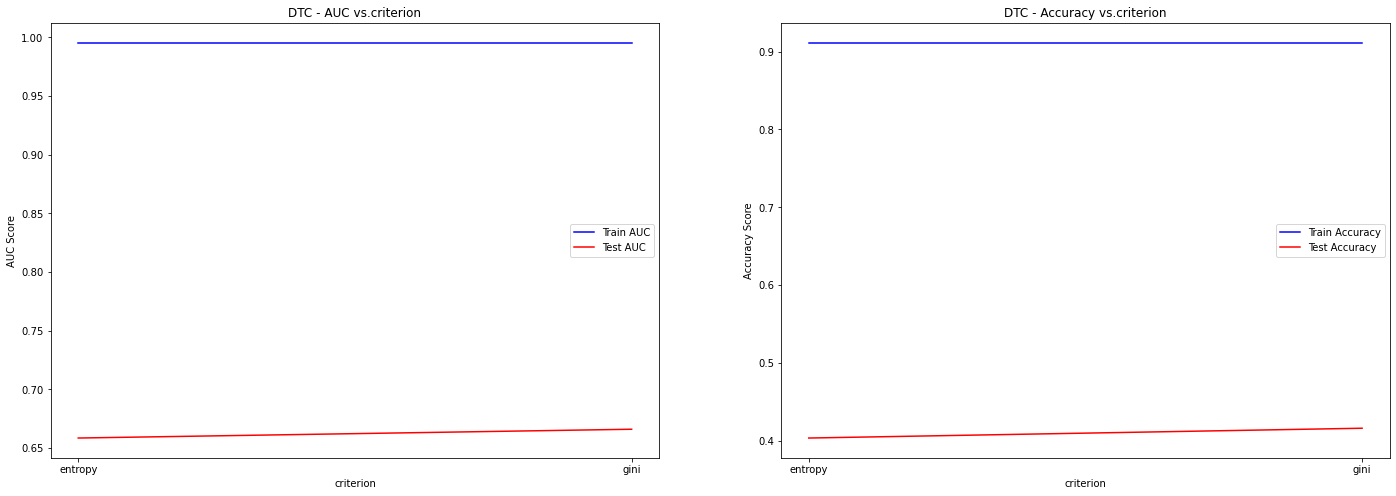

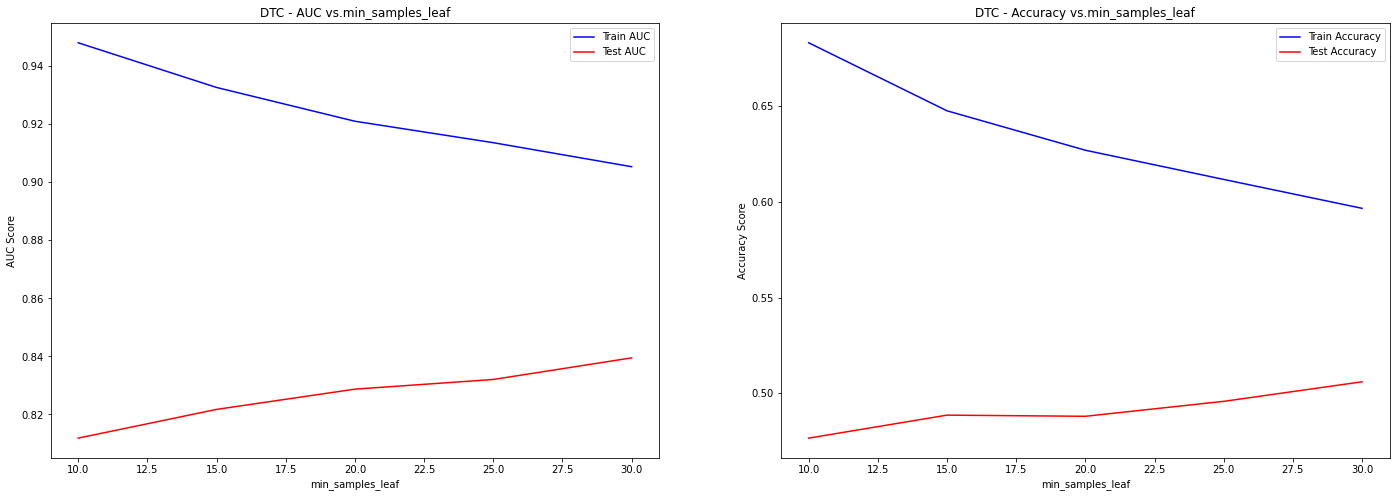

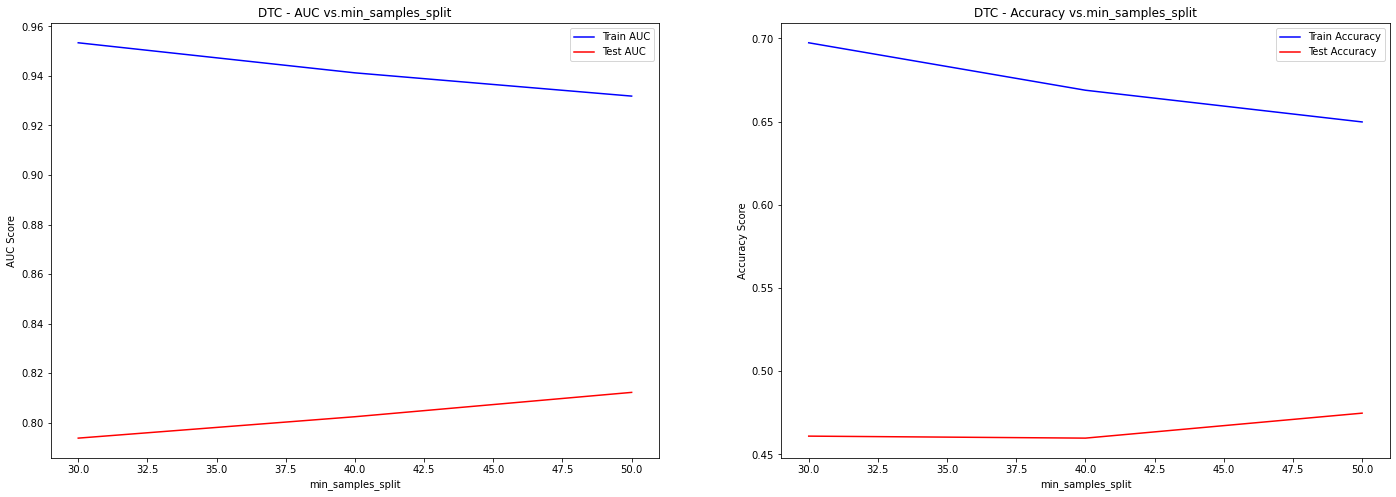

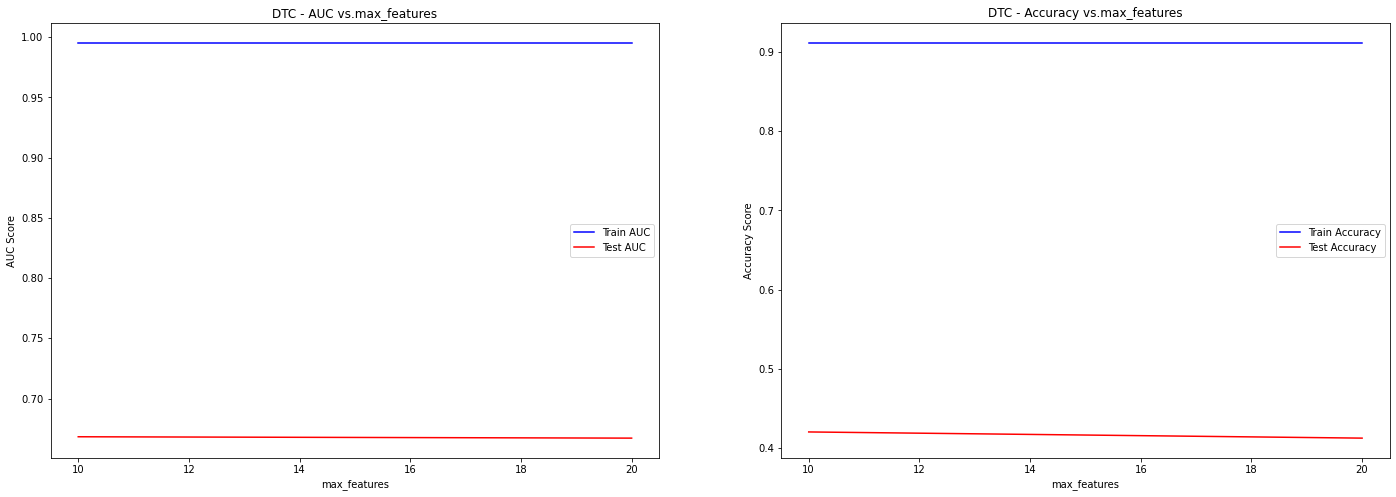

In [311]:
hyper_params = [{'max_depth' : [10,15,20]},
                {'criterion' : ['entropy','gini']}, 
                {'min_samples_leaf' : [10,15,20,25,30]}, 
                {'min_samples_split' : [30,40,50]}, 
                {'max_features' : [10,20]}]

# Tuning each hyperparamter individually

for parameter in hyper_params:
    hyper_param_tuning_DTC(list(parameter.keys())[0], parameter[list(parameter.keys())[0]])

The above graphs show how AUC and Accuracy scores are affected while tuning various Decision Tree Classifier hyperparameters. This analysis helps us to identify the ideal ranges for these hyperparameters keeping the others constant. I will next create a grid and use GridSearchCV to test values based on what I see from the plots above.

In [279]:
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [14, 15, 16],
    'min_samples_split': [40, 45, 50],
    'min_samples_leaf': [30, 35, 40],
    'max_features': [20, 25]

}

gs_tree = GridSearchCV(clf, param_grid, cv=3)
gs_tree.fit(X_train_resampled, y_train_resampled)

gs_tree.best_params_

{'criterion': 'gini',
 'max_depth': 16,
 'max_features': 25,
 'min_samples_leaf': 40,
 'min_samples_split': 40}

In [283]:
DTC_best = DecisionTreeClassifier(criterion = 'gini', 
                                  max_depth = 16, 
                                  min_samples_split = 40, 
                                  min_samples_leaf = 40, 
                                  max_features = 25,
                                  random_state = 1)
DTC_best.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=16, max_features=25, min_samples_leaf=40,
                       min_samples_split=40, random_state=1)

In [284]:
y_pred_train_best = DTC_best.predict(X_train_resampled)

print(classification_report(y_train_resampled, y_pred_train_best))

              precision    recall  f1-score   support

         edm       0.70      0.76      0.73       937
      hiphop       0.52      0.53      0.53       937
       latin       0.56      0.55      0.56       937
         pop       0.52      0.44      0.48       937
         r&b       0.52      0.54      0.53       937
         rap       0.54      0.57      0.55       937
        rock       0.72      0.69      0.71       937

    accuracy                           0.58      6559
   macro avg       0.58      0.58      0.58      6559
weighted avg       0.58      0.58      0.58      6559



In [285]:
y_pred_test_best = DTC_best.predict(X_test_resampled)

print(classification_report(y_test_resampled, y_pred_test_best))

              precision    recall  f1-score   support

         edm       0.63      0.66      0.65       238
      hiphop       0.43      0.47      0.45       238
       latin       0.47      0.42      0.44       238
         pop       0.42      0.37      0.39       238
         r&b       0.40      0.46      0.43       238
         rap       0.44      0.46      0.45       238
        rock       0.69      0.61      0.65       238

    accuracy                           0.49      1666
   macro avg       0.50      0.49      0.49      1666
weighted avg       0.50      0.49      0.49      1666



### RANDOM FOREST MODEL

In [312]:
## Model V2 - Baseline Random Forest

forest = RandomForestClassifier(n_estimators = 100, random_state = 1)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=1)

In [313]:
forest.score(X_train_resampled, y_train_resampled)

0.9115718859582254

In [314]:
forest.score(X_test_resampled, y_test_resampled)

0.5696278511404562

In [319]:
## Function for tuning hyperparameters to adjust for overfitting - RFC

def hyper_param_tuning_RFC(feature, feature_range):
    
    train_AUC_results_total = []
    test_AUC_results_total = []
    train_accuracy_results_total = []
    test_accuracy_results_total = []
    
    for value in feature_range:
        if feature == 'max_depth':
            RFC = RandomForestClassifier(max_depth = value, random_state = 1)
        elif feature == 'max_features':
            RFC = RandomForestClassifier(max_features = value, random_state = 1)
        elif feature == 'criterion':
            RFC = RandomForestClassifier(criterion = value, random_state = 1)
        elif feature == 'min_samples_leaf':
            RFC = RandomForestClassifier(min_samples_leaf = value, random_state = 1)
        elif feature == 'min_samples_split':
            RFC = RandomForestClassifier(min_samples_split = value, random_state = 1)

        RFC.fit(X_train_resampled, y_train_resampled)
        y_pred_train_proba = RFC.predict_proba(X_train_resampled)
        roc_auc_train = roc_auc_score(y_train_resampled, y_pred_train_proba, multi_class = 'ovr')
        y_pred_train = RFC.predict(X_train_resampled)
        train_accuracy = accuracy_score(y_train_resampled, y_pred_train)

        y_pred_test_proba = RFC.predict_proba(X_test_resampled)
        roc_auc_test = roc_auc_score(y_test_resampled, y_pred_test_proba, multi_class = 'ovr')
        y_pred_test = RFC.predict(X_test_resampled)
        test_accuracy = accuracy_score(y_test_resampled, y_pred_test)

        scores = {'Train AUC': roc_auc_train, 
        'Train Accuracy' : train_accuracy, 
        'Test AUC' : roc_auc_test, 
        'Test Accuracy' : test_accuracy}

        train_AUC_results_total.append(scores['Train AUC'])
        test_AUC_results_total.append(scores['Test AUC'])
        train_accuracy_results_total.append(scores['Train Accuracy'])
        test_accuracy_results_total.append(scores['Test Accuracy'])
    
    
            
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (24,8))

    ax1.plot(feature_range, train_AUC_results_total, 'b', label='Train AUC')
    ax1.plot(feature_range, test_AUC_results_total, 'r', label='Test AUC')
    ax1.set_ylabel('AUC Score')
    ax1.set_xlabel(feature)
    ax1.set_title('DTC - AUC vs.' + feature)
    ax1.legend()

    ax2.plot(feature_range, train_accuracy_results_total, 'b', label='Train Accuracy')
    ax2.plot(feature_range, test_accuracy_results_total, 'r', label='Test Accuracy')
    ax2.set_ylabel('Accuracy Score')
    ax2.set_xlabel(feature)
    ax2.set_title('DTC - Accuracy vs.' + feature)
    ax2.legend()

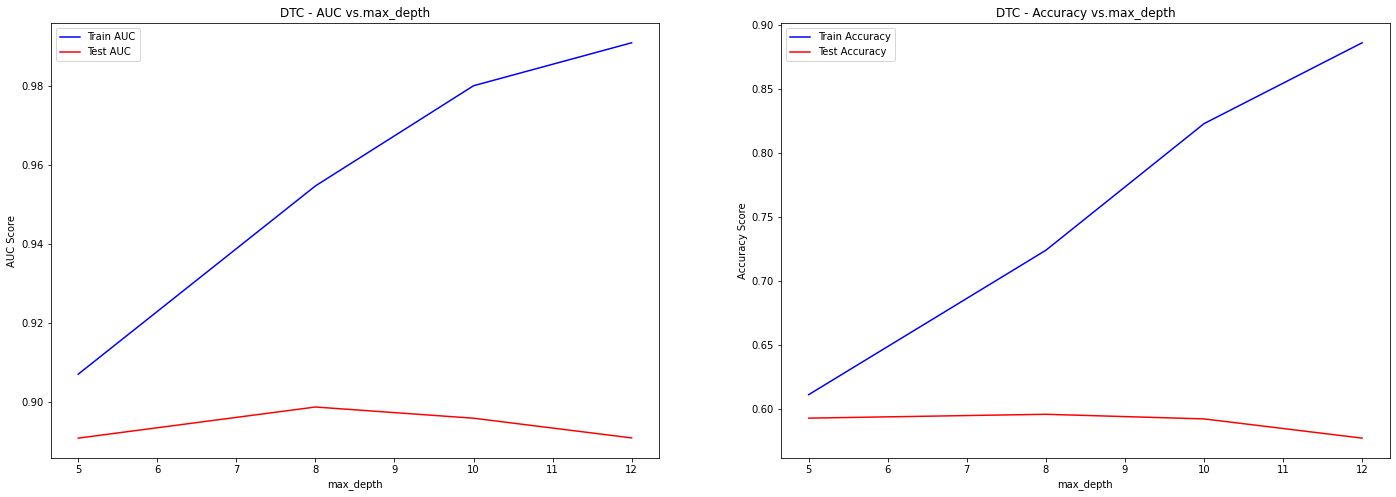

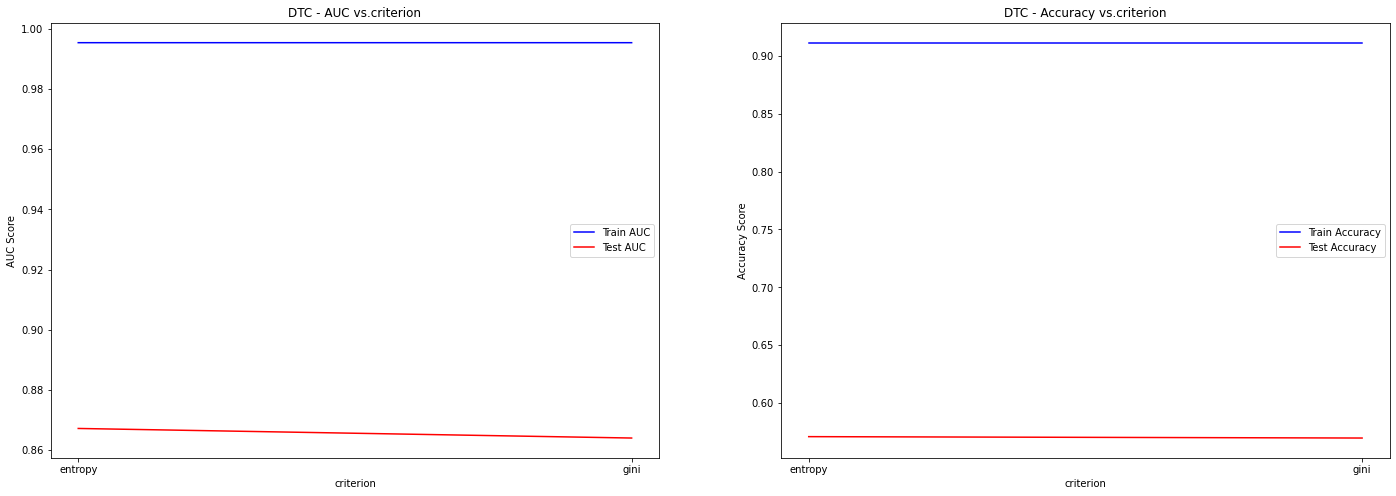

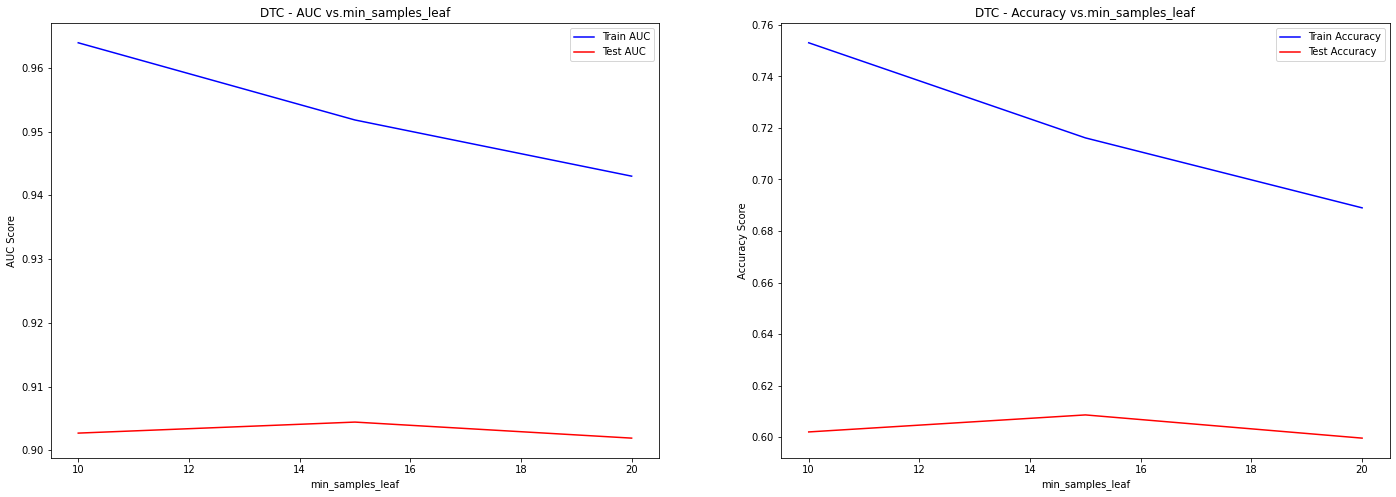

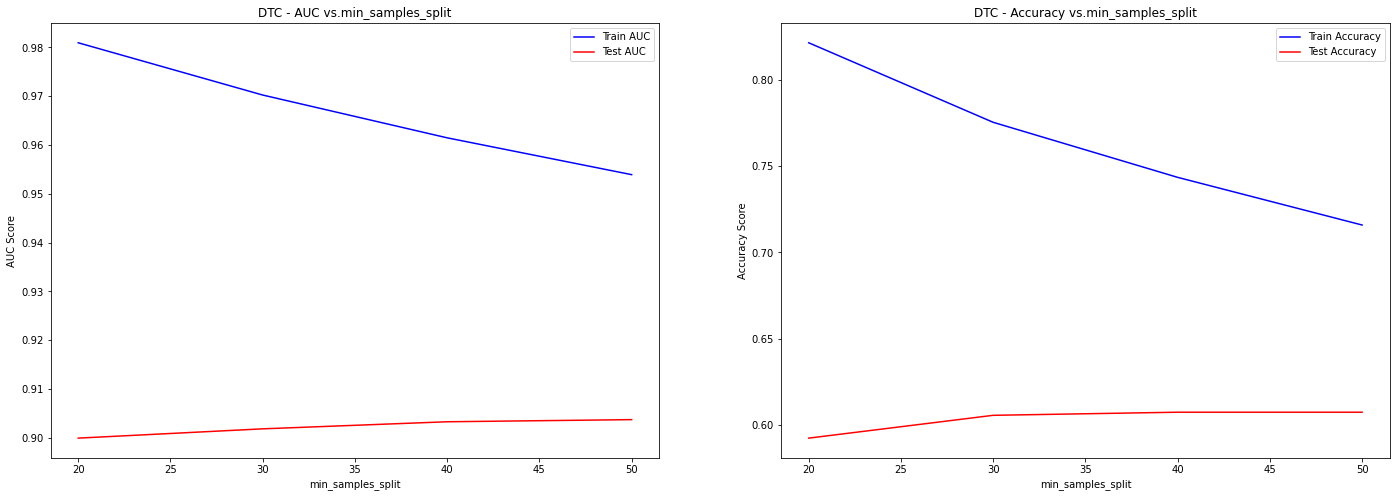

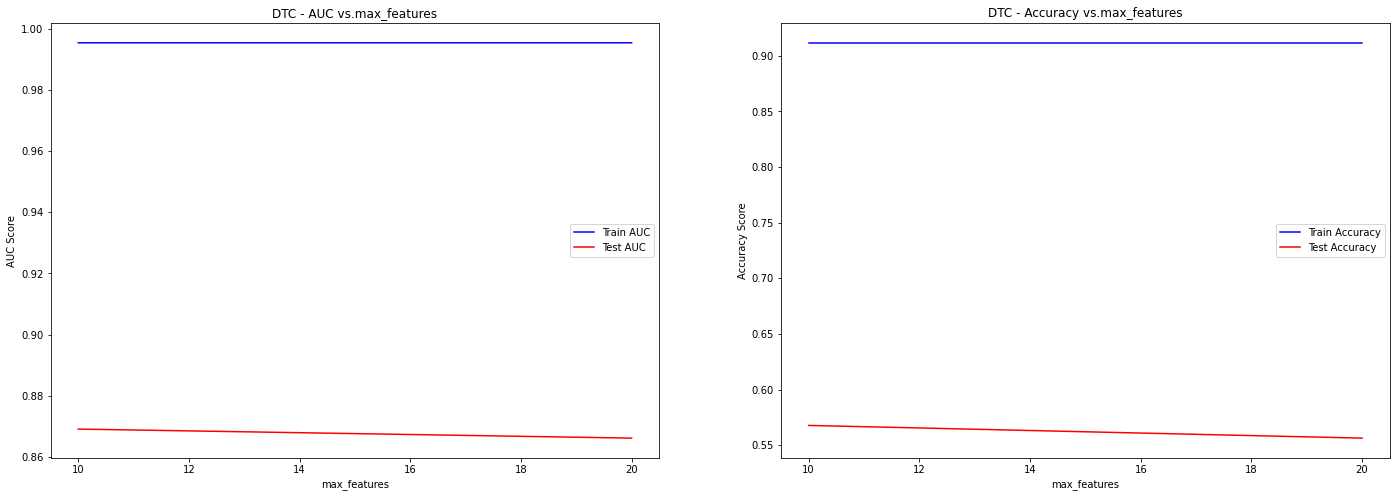

In [322]:
hyper_params = [{'max_depth' : [5,8,10,12]},
                {'criterion' : ['entropy','gini']}, 
                {'min_samples_leaf' : [10,15,20]}, 
                {'min_samples_split' : [20,30,40,50]}, 
                {'max_features' : [10,20]}]

# Tuning each hyperparamter individually

for parameter in hyper_params:
    hyper_param_tuning_RFC(list(parameter.keys())[0], parameter[list(parameter.keys())[0]])

In [36]:
forest_clf = RandomForestClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100],
    'max_depth': [8, 10, 12],
    'min_samples_split': [20, 25, 30, 40],

}

gs_forest = GridSearchCV(forest_clf, param_grid, cv=3)
gs_forest.fit(X_train_resampled, y_train_resampled)

gs_forest.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_split': 25,
 'n_estimators': 100}

In [37]:
forest2 = RandomForestClassifier(criterion = 'gini', max_depth = 12, n_estimators = 100, min_samples_split = 30, random_state = 1)
forest2.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=12, min_samples_split=30, random_state=1)

In [38]:
forest2.score(X_train_resampled, y_train_resampled)

0.7612440920872084

In [39]:
forest2.score(X_test_resampled, y_test_resampled)

0.6020408163265306

### BINARY CLASSIFICATION TESTING

### HipHop vs. Not HipHop

In [40]:
## What if we treat this like a binary classification problem? hip hop or not hiphop for example

y_train_binary_hiphop = y_train.replace(['pop','r&b','rap','rock','edm','latin'],'not_hiphop')
y_test_binary_hiphop = y_test.replace(['pop','r&b','rap','rock','edm','latin'],'not_hiphop')

In [41]:
y_train_binary_hiphop.value_counts()

not_hiphop    4741
hiphop         792
Name: Genre, dtype: int64

The value counts noted above indicate a large imbalance in class - more than 5 times as many non_hiphop songs than hiphop songs. I will address this using SMOTE.

In [42]:
print(y_train_binary_hiphop.value_counts())

X_train_binary_hiphop_resampled, y_train_binary_hiphop_resampled = SMOTE().fit_resample(X_train_OHE, y_train_binary_hiphop)

print(pd.Series(y_train_binary_hiphop_resampled).value_counts()) 

not_hiphop    4741
hiphop         792
Name: Genre, dtype: int64
hiphop        4741
not_hiphop    4741
Name: Genre, dtype: int64


In [43]:
print(y_test_binary_hiphop.value_counts())

X_test_binary_hiphop_resampled, y_test_binary_hiphop_resampled = SMOTE().fit_resample(X_test_OHE, y_test_binary_hiphop)

print(pd.Series(y_test_binary_hiphop_resampled).value_counts()) 

not_hiphop    1205
hiphop         179
Name: Genre, dtype: int64
not_hiphop    1205
hiphop        1205
Name: Genre, dtype: int64


In [44]:
clf_binary_hiphop = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [14, 15, 16],
    'min_samples_split': [44, 45, 46],
    'min_samples_leaf': [15, 16, 17, 18],
    'max_features': [20, 25]

}

gs_tree = GridSearchCV(clf_binary_hiphop, param_grid, cv=3)
gs_tree.fit(X_train_binary_hiphop_resampled, y_train_binary_hiphop_resampled)

gs_tree.best_params_

{'criterion': 'gini',
 'max_depth': 14,
 'max_features': 20,
 'min_samples_leaf': 15,
 'min_samples_split': 46}

In [45]:
DTC_best_binary_hiphop = DecisionTreeClassifier(criterion = 'gini', 
                                  max_depth = 16, 
                                  min_samples_split = 46, 
                                  min_samples_leaf = 15, 
                                  max_features = 20,
                                  random_state = 1)

DTC_best_binary_hiphop.fit(X_train_binary_hiphop_resampled, y_train_binary_hiphop_resampled)

DecisionTreeClassifier(max_depth=16, max_features=20, min_samples_leaf=15,
                       min_samples_split=46, random_state=1)

In [46]:
y_pred_train_best_binary_hiphop = DTC_best_binary_hiphop.predict(X_train_binary_hiphop_resampled)

print(classification_report(y_train_binary_hiphop_resampled, y_pred_train_best_binary_hiphop))

              precision    recall  f1-score   support

      hiphop       0.88      0.90      0.89      4741
  not_hiphop       0.89      0.87      0.88      4741

    accuracy                           0.88      9482
   macro avg       0.89      0.88      0.88      9482
weighted avg       0.89      0.88      0.88      9482



In [47]:
y_pred_test_best_binary_hiphop = DTC_best_binary_hiphop.predict(X_test_binary_hiphop_resampled)

print(classification_report(y_test_binary_hiphop_resampled, y_pred_test_best_binary_hiphop))

              precision    recall  f1-score   support

      hiphop       0.83      0.82      0.83      1205
  not_hiphop       0.82      0.83      0.83      1205

    accuracy                           0.83      2410
   macro avg       0.83      0.83      0.83      2410
weighted avg       0.83      0.83      0.83      2410



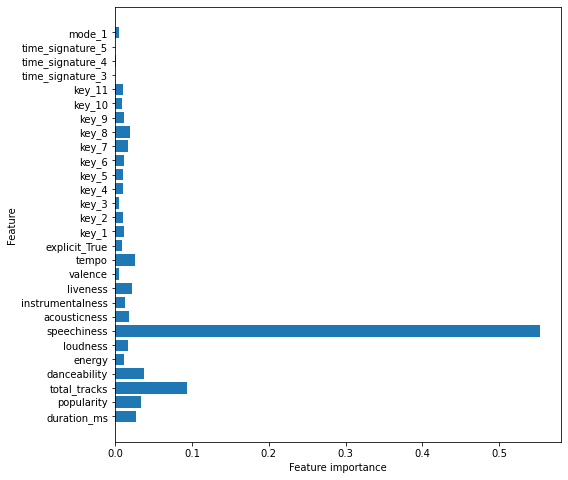

In [48]:
def plot_feature_importances(model):
    n_features = X_train_OHE.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_OHE.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(DTC_best_binary_hiphop)

It looks like binary classification yielded much better results than did multi-class. I will now define a function that repeats the above-steps generalized to all genres so that I can repeat this analysis for each. I will also add a Random Forest model for each genre to see the improved performance compared to the Decision Tree model.

In [227]:
def genre_summary_report(genre):
    
    # Transform target variables into binary based on genre input
    train_remove_list = list(y_train.unique())
    train_remove_list.remove(genre)
    
    test_remove_list = list(y_test.unique())
    test_remove_list.remove(genre)
        
    y_train_binary = y_train.replace(train_remove_list,'not_' + genre)
    y_test_binary = y_test.replace(test_remove_list,'not_' + genre)
    
    # Resample to adjust for class imbalance
    X_train_binary_resampled, y_train_binary_resampled = SMOTE().fit_resample(X_train_OHE, y_train_binary)
    X_test_binary_resampled, y_test_binary_resampled = SMOTE().fit_resample(X_test_OHE, y_test_binary)
    
    # Test DTC Parameters
    clf_binary = DecisionTreeClassifier()

    param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [14, 15, 16],
    'min_samples_split': [44, 45, 46],
    'min_samples_leaf': [15, 16, 17, 18],
    'max_features': [20, 25]}

    gs_tree = GridSearchCV(clf_binary, param_grid, cv=3)
    gs_tree.fit(X_train_binary_resampled, y_train_binary_resampled)

    params = gs_tree.best_params_
    
    
    # Tune Decision Tree with best parameters
    DTC_best_binary = DecisionTreeClassifier(criterion = params['criterion'], 
                                  max_depth = params['max_depth'], 
                                  min_samples_split = params['min_samples_split'], 
                                  min_samples_leaf = params['min_samples_leaf'], 
                                  max_features = params['max_features'],
                                  random_state = 1)

    DTC_best_binary.fit(X_train_binary_resampled, y_train_binary_resampled)
    
    # Use tuned model to predict values
    y_pred_train_best_binary = DTC_best_binary.predict(X_train_binary_resampled)
    y_pred_test_best_binary = DTC_best_binary.predict(X_test_binary_resampled)
    
    # Test RFC Parameters
    clf_binary2 = RandomForestClassifier()

    param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [14, 15],
    'min_samples_split': [44, 45],}

    gs_forest = GridSearchCV(clf_binary2, param_grid, cv=3)
    gs_forest.fit(X_train_binary_resampled, y_train_binary_resampled)

    params2 = gs_forest.best_params_
    
    
    # Tune Random Forest with best parameters
    RFC_best_binary = RandomForestClassifier(criterion = params['criterion'], 
                                  max_depth = params['max_depth'], 
                                  min_samples_split = params['min_samples_split'], 
                                  random_state = 1)

    RFC_best_binary.fit(X_train_binary_resampled, y_train_binary_resampled)
    
    # Use tuned model to predict values
    y_pred_train_best_binary2 = RFC_best_binary.predict(X_train_binary_resampled)
    y_pred_test_best_binary2 = RFC_best_binary.predict(X_test_binary_resampled)
    
    # Return performance summary
    print(color.BOLD + genre,'-','DTC Train Performance:' + color.END)
    print(classification_report(y_train_binary_resampled, y_pred_train_best_binary))
    print(color.BOLD + genre,'-','DTC Test Performance:' + color.END)
    print(classification_report(y_test_binary_resampled, y_pred_test_best_binary))
    print(color.BOLD + genre,'-','RFC Train Performance:' + color.END)
    print(classification_report(y_train_binary_resampled, y_pred_train_best_binary2))
    print(color.BOLD + genre,'-','RFC Test Performance:' + color.END)
    print(classification_report(y_test_binary_resampled, y_pred_test_best_binary2))
    plot_feature_importances(DTC_best_binary)

rock - DTC Train Performance:
              precision    recall  f1-score   support

    not_rock       0.94      0.92      0.93      4635
        rock       0.92      0.95      0.93      4635

    accuracy                           0.93      9270
   macro avg       0.93      0.93      0.93      9270
weighted avg       0.93      0.93      0.93      9270

rock - DTC Test Performance:
              precision    recall  f1-score   support

    not_rock       0.88      0.87      0.87      1146
        rock       0.87      0.88      0.87      1146

    accuracy                           0.87      2292
   macro avg       0.87      0.87      0.87      2292
weighted avg       0.87      0.87      0.87      2292

rock - RFC Train Performance:
              precision    recall  f1-score   support

    not_rock       0.96      0.96      0.96      4635
        rock       0.96      0.96      0.96      4635

    accuracy                           0.96      9270
   macro avg       0.96      0.96      

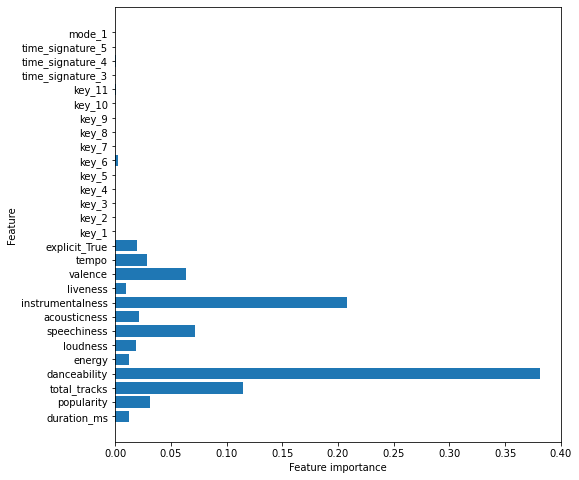

In [228]:
genre_summary_report('rock')

### R&B vs. Not R&B

r&b - DTC Train Performance:
              precision    recall  f1-score   support

     not_r&b       0.89      0.89      0.89      4957
         r&b       0.89      0.89      0.89      4957

    accuracy                           0.89      9914
   macro avg       0.89      0.89      0.89      9914
weighted avg       0.89      0.89      0.89      9914

r&b - DTC Test Performance:
              precision    recall  f1-score   support

     not_r&b       0.79      0.86      0.82      1229
         r&b       0.85      0.77      0.81      1229

    accuracy                           0.82      2458
   macro avg       0.82      0.82      0.82      2458
weighted avg       0.82      0.82      0.82      2458

r&b - RFC Train Performance:
              precision    recall  f1-score   support

     not_r&b       0.93      0.94      0.94      4957
         r&b       0.94      0.93      0.93      4957

    accuracy                           0.94      9914
   macro avg       0.94      0.94      0.9

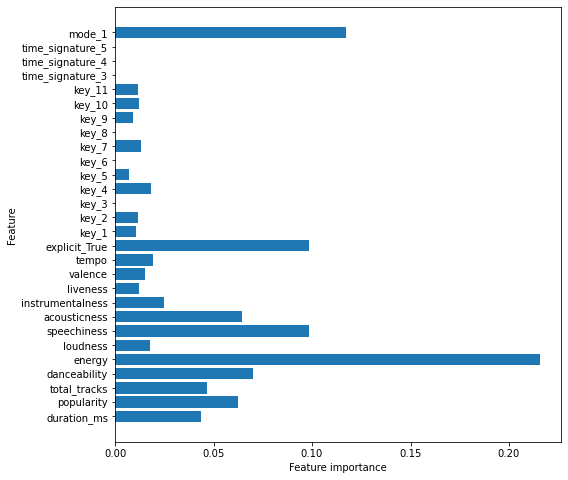

In [229]:
genre_summary_report('r&b')

rap - DTC Train Performance:
              precision    recall  f1-score   support

     not_rap       0.88      0.89      0.89      4785
         rap       0.89      0.88      0.89      4785

    accuracy                           0.89      9570
   macro avg       0.89      0.89      0.89      9570
weighted avg       0.89      0.89      0.89      9570

rap - DTC Test Performance:
              precision    recall  f1-score   support

     not_rap       0.80      0.86      0.83      1206
         rap       0.85      0.78      0.81      1206

    accuracy                           0.82      2412
   macro avg       0.82      0.82      0.82      2412
weighted avg       0.82      0.82      0.82      2412

rap - RFC Train Performance:
              precision    recall  f1-score   support

     not_rap       0.94      0.88      0.91      4785
         rap       0.89      0.95      0.92      4785

    accuracy                           0.91      9570
   macro avg       0.92      0.91      0.9

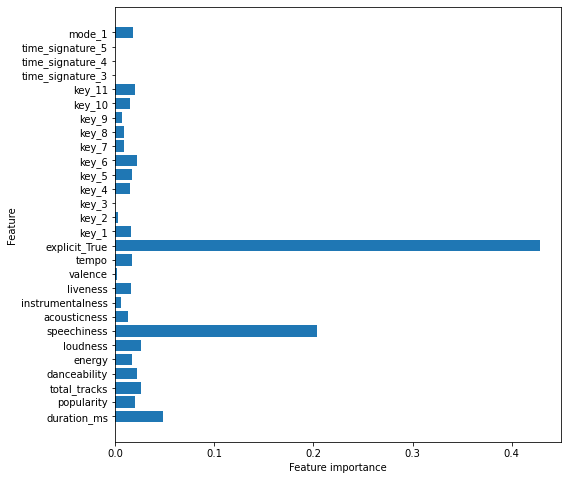

In [230]:
genre_summary_report('rap')

hiphop - DTC Train Performance:
              precision    recall  f1-score   support

      hiphop       0.88      0.88      0.88      4741
  not_hiphop       0.88      0.88      0.88      4741

    accuracy                           0.88      9482
   macro avg       0.88      0.88      0.88      9482
weighted avg       0.88      0.88      0.88      9482

hiphop - DTC Test Performance:
              precision    recall  f1-score   support

      hiphop       0.84      0.79      0.81      1205
  not_hiphop       0.80      0.85      0.82      1205

    accuracy                           0.82      2410
   macro avg       0.82      0.82      0.82      2410
weighted avg       0.82      0.82      0.82      2410

hiphop - RFC Train Performance:
              precision    recall  f1-score   support

      hiphop       0.90      0.93      0.91      4741
  not_hiphop       0.93      0.89      0.91      4741

    accuracy                           0.91      9482
   macro avg       0.91      0.91

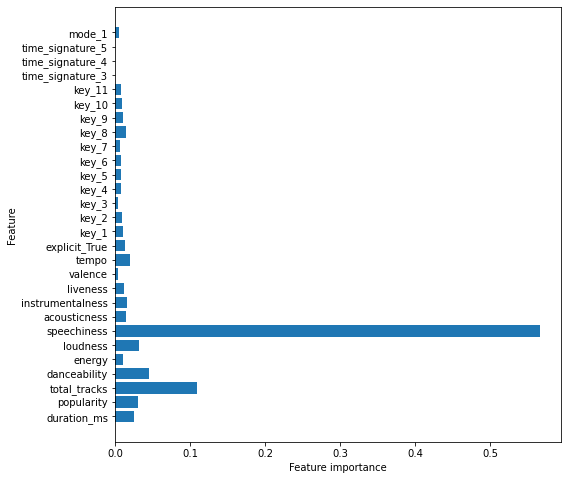

In [231]:
genre_summary_report('hiphop')

latin - DTC Train Performance:
              precision    recall  f1-score   support

       latin       0.87      0.91      0.89      4694
   not_latin       0.91      0.86      0.88      4694

    accuracy                           0.89      9388
   macro avg       0.89      0.89      0.89      9388
weighted avg       0.89      0.89      0.89      9388

latin - DTC Test Performance:
              precision    recall  f1-score   support

       latin       0.81      0.83      0.82      1187
   not_latin       0.83      0.80      0.81      1187

    accuracy                           0.82      2374
   macro avg       0.82      0.82      0.82      2374
weighted avg       0.82      0.82      0.82      2374

latin - RFC Train Performance:
              precision    recall  f1-score   support

       latin       0.92      0.94      0.93      4694
   not_latin       0.94      0.92      0.93      4694

    accuracy                           0.93      9388
   macro avg       0.93      0.93   

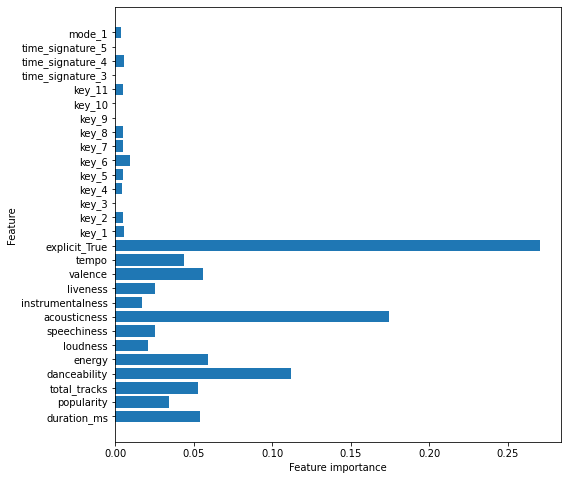

In [232]:
genre_summary_report('latin')

edm - DTC Train Performance:
              precision    recall  f1-score   support

         edm       0.94      0.93      0.93      4790
     not_edm       0.93      0.94      0.94      4790

    accuracy                           0.94      9580
   macro avg       0.94      0.94      0.94      9580
weighted avg       0.94      0.94      0.94      9580

edm - DTC Test Performance:
              precision    recall  f1-score   support

         edm       0.92      0.86      0.89      1171
     not_edm       0.87      0.93      0.90      1171

    accuracy                           0.89      2342
   macro avg       0.90      0.89      0.89      2342
weighted avg       0.90      0.89      0.89      2342

edm - RFC Train Performance:
              precision    recall  f1-score   support

         edm       0.98      0.96      0.97      4790
     not_edm       0.96      0.98      0.97      4790

    accuracy                           0.97      9580
   macro avg       0.97      0.97      0.9

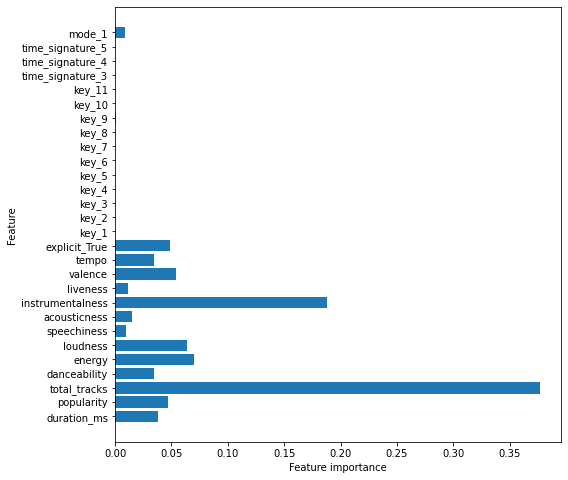

In [233]:
genre_summary_report('edm')

pop - DTC Train Performance:
              precision    recall  f1-score   support

     not_pop       0.88      0.86      0.87      4596
         pop       0.86      0.89      0.88      4596

    accuracy                           0.87      9192
   macro avg       0.87      0.87      0.87      9192
weighted avg       0.87      0.87      0.87      9192

pop - DTC Test Performance:
              precision    recall  f1-score   support

     not_pop       0.77      0.78      0.78      1160
         pop       0.78      0.76      0.77      1160

    accuracy                           0.77      2320
   macro avg       0.77      0.77      0.77      2320
weighted avg       0.77      0.77      0.77      2320

pop - RFC Train Performance:
              precision    recall  f1-score   support

     not_pop       0.93      0.90      0.92      4596
         pop       0.91      0.93      0.92      4596

    accuracy                           0.92      9192
   macro avg       0.92      0.92      0.9

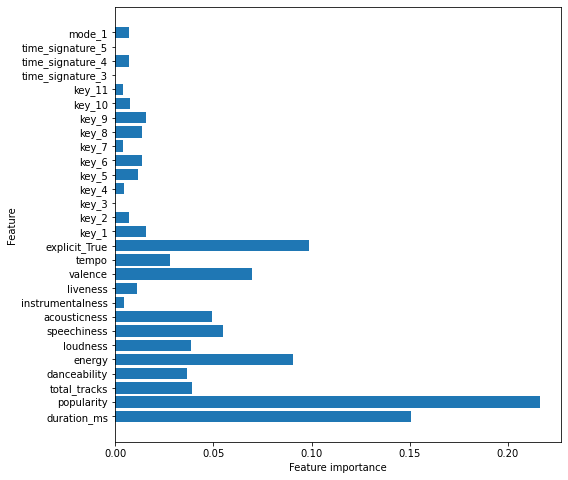

In [234]:
genre_summary_report('pop')

# Evaluation

Not surprisingly, popularity is the most important feature for predicting pop. It is interesting though that explicit_True is the second most important feature. This might suggest that pop songs tend to be clean and not explicit. It also seems as though duration is an important feature - suggesting pop songs are either significantly shorter or longer than songs of other genres.

The above feature importances show a very interesting distinction between hiphop (which was the first genre we tested this binary classification on) and rap. It seems that for both genres, speechiness is a very important feature, however for rap - explicit_True is even more important than speechiness. This seems to be a key distinction between the two genres our model has picked up on.

The above makes sense intuitvely because hiphop as a genre is very-much-so about the lyrics. I will explore the rap genre next because it is most similar to hiphop.

Explicit_True and acousticness appear to be the two most important features to predicting latin music. This might suggest acoustic instruments are prevalent in the genre.

From the feature importances above - it seems as though total_tracks (a measure of how many tracks a particular artist of a song has) is the most important feature. This suggests that edm artists have more songs to their names than do other types of artists. It also makes sense that instrumentalness is the next most important feature because edm songs typically have less vocals than do songs of other genres.

Energy and mode(key - major vs. minor) are the most important features for predicting r&b. This might suggest that r&b songs are slower than songs of other genres and perhaps more often in minor key (which also affects mood).

Danceability seems to be the most important feature for predicting rock songs. This might suggest that rock songs are considerably less danceable than the other genres which would make sense. Instrumentalness is the second most important feature and might suggest rock songs are more instrument-heavy than songs of other genres.